In [3]:
import os
import glob
import subprocess
import numpy as np
from numpy import cov
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import optimize
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.timeseries import LombScargle
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAperture
from photutils import CircularAnnulus

def test_func(x, a, b, c, d):
    return a * np.sin(b * x + c) + d

# %matplotlib tk

In [5]:
files = glob.glob('data/*.fits')

In [6]:
columns = ['JD(seconds)']
jd = []
jdai = []
for i in range(len(files)):
    jd.append(float(files[i][10:23])*86400)
    jdai.append(float(files[i][10:23]))

df = pd.DataFrame(columns=columns)
df['JD(seconds)'] = jd
df['JD'] = jdai

df

,JD(seconds),JD
0,2.118434e+11,2.451891e+06
1,2.118435e+11,2.451892e+06
2,2.118434e+11,2.451891e+06
3,2.118434e+11,2.451891e+06
4,2.118437e+11,2.451894e+06
...,...,...
63,2.118435e+11,2.451892e+06
64,2.118435e+11,2.451893e+06
65,2.118436e+11,2.451894e+06
66,2.118435e+11,2.451893e+06


## Aperture Photometry

In [7]:
aperture_1 = []
aperture_2 = []
aperture_3 = []


for i in range(len(files)):
    nest_list = []
    hdu = fits.open(files[i])

    w = WCS(hdu[0].header)

#     positions = [(100., 100.),(41,115.5),(150,143)]
#     positions = [(101., 101.),(104,159),(103.5,172.5)]
#     positions = [(101., 101.),(70,99),(103.5,172.5)]

    positions = [(101., 101.),(73.2,118.2),(103,172.5)]
#     positions = [(101., 101.),(73.2,118.2),(103.5,172.5)]
    

    aperture = CircularAperture(positions, r=6.)

    image = hdu[0].data

    annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=13)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'  # for consistent table output

    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output

    aperture_1.append(phot_table['residual_aperture_sum'][0])
    aperture_2.append(phot_table['residual_aperture_sum'][1])
    aperture_3.append(phot_table['residual_aperture_sum'][2])

 [astropy.io.fits.verify]
Changed DATE-OBS from '17/12/2000' to '2000-12-17''. [astropy.wcs.wcs]
Changed DATE-OBS from '28/12/2000' to '2000-12-28''. [astropy.wcs.wcs]
Changed DATE-OBS from '28/01/2001' to '2001-01-28''. [astropy.wcs.wcs]
Changed DATE-OBS from '15/12/2000' to '2000-12-15''. [astropy.wcs.wcs]
Changed DATE-OBS from '02/01/2001' to '2001-01-02''. [astropy.wcs.wcs]
Changed DATE-OBS from '17/01/2001' to '2001-01-17''. [astropy.wcs.wcs]
Changed DATE-OBS from '05/02/2001' to '2001-02-05''. [astropy.wcs.wcs]
Changed DATE-OBS from '24/01/2001' to '2001-01-24''. [astropy.wcs.wcs]
Changed DATE-OBS from '21/12/2000' to '2000-12-21''. [astropy.wcs.wcs]
Changed DATE-OBS from '01/02/2001' to '2001-02-01''. [astropy.wcs.wcs]
Changed DATE-OBS from '01/01/2001' to '2001-01-01''. [astropy.wcs.wcs]
Changed DATE-OBS from '30/01/2001' to '2001-01-30''. [astropy.wcs.wcs]
Changed DATE-OBS from '04/02/2001' to '2001-02-04''. [astropy.wcs.wcs]
Changed DATE-OBS from '22/01/2001' to '2001-01-22''

## Differential Photometry

In [8]:
df['residual_aperture_sum_1'] = aperture_1
df['residual_aperture_sum_2'] = aperture_2
df['residual_aperture_sum_3'] = aperture_3

df['ins_mag_1'] = -2.5*np.log(df['residual_aperture_sum_1'])
df['ins_mag_2'] = -2.5*np.log(df['residual_aperture_sum_2'])
df['ins_mag_3'] = -2.5*np.log(df['residual_aperture_sum_3'])

df['diff_mag_1'] = df['ins_mag_1']-df['ins_mag_3']
df['diff_mag_2'] = df['ins_mag_2']-df['ins_mag_3']
df['diff_mag_3'] = df['ins_mag_3']-df['ins_mag_3']

df

,JD(seconds),JD,residual_aperture_sum_1,residual_aperture_sum_2,residual_aperture_sum_3,ins_mag_1,ins_mag_2,ins_mag_3,diff_mag_1,diff_mag_2,diff_mag_3
0,2.118434e+11,2.451891e+06,14430.320889,121142.345510,113838.175256,-23.942717,-29.261804,-29.106333,5.163616,-0.155471,0.0
1,2.118435e+11,2.451892e+06,4162.407179,37613.556798,36421.435689,-20.834622,-26.337800,-26.257282,5.422660,-0.080518,0.0
2,2.118434e+11,2.451891e+06,16654.239669,119936.235002,122230.554717,-24.301050,-29.236789,-29.284161,4.983111,0.047372,0.0
3,2.118434e+11,2.451891e+06,15189.895728,116235.300965,117413.460319,-24.070964,-29.158430,-29.183642,5.112678,0.025212,0.0
4,2.118437e+11,2.451894e+06,17104.785811,124109.375352,121853.757766,-24.367784,-29.322296,-29.276442,4.908658,-0.045854,0.0
...,...,...,...,...,...,...,...,...,...,...,...
63,2.118435e+11,2.451892e+06,9744.843445,79014.607368,75876.753328,-22.961234,-28.193470,-28.092164,5.130930,-0.101306,0.0
64,2.118435e+11,2.451893e+06,15729.997736,118397.049119,119805.729902,-24.158312,-29.204498,-29.234067,5.075755,0.029569,0.0
65,2.118436e+11,2.451894e+06,14192.941138,122433.396516,117018.778501,-23.901250,-29.288306,-29.175224,5.273974,-0.113082,0.0
66,2.118435e+11,2.451893e+06,12576.602360,94936.683607,97906.088030,-23.598984,-28.652414,-28.729410,5.130427,0.076996,0.0


In [142]:
df = df.sort_values(by=['JD(seconds)'])
df = df.reset_index(drop=True)
# df.to_csv('data.csv')
df

,JD(seconds),JD,residual_aperture_sum_1,residual_aperture_sum_2,residual_aperture_sum_3,ins_mag_1,ins_mag_2,ins_mag_3,diff_mag_1,diff_mag_2,diff_mag_3
0,2.118434e+11,2.451891e+06,17045.862694,120860.902408,121980.383524,-24.359157,-29.255989,-29.279039,4.919882,0.023050,0.0
1,2.118434e+11,2.451891e+06,18725.793692,120157.112515,125690.864465,-24.594143,-29.241389,-29.353952,4.759809,0.112563,0.0
2,2.118434e+11,2.451891e+06,14910.494799,116295.951683,113681.191125,-24.024551,-29.159734,-29.102883,5.078332,-0.056851,0.0
3,2.118434e+11,2.451891e+06,15189.895728,116235.300965,117413.460319,-24.070964,-29.158430,-29.183642,5.112678,0.025212,0.0
4,2.118434e+11,2.451891e+06,15029.989218,112994.577985,115575.903251,-24.044507,-29.087738,-29.144207,5.099700,0.056469,0.0
...,...,...,...,...,...,...,...,...,...,...,...
63,2.118437e+11,2.451894e+06,21745.129419,123040.407718,129132.835953,-24.967863,-29.300670,-29.421492,4.453630,0.120822,0.0
64,2.118437e+11,2.451895e+06,17980.222019,112897.929273,114868.431139,-24.492569,-29.085599,-29.128857,4.636288,0.043258,0.0
65,2.118437e+11,2.451895e+06,18515.318741,100608.559082,106154.684557,-24.565884,-28.797482,-28.931631,4.365747,0.134150,0.0
66,2.118437e+11,2.451895e+06,18530.102162,106923.364736,110902.153894,-24.567880,-28.949669,-29.041009,4.473129,0.091340,0.0


[2.74112042e-01 3.99999332e-05 5.10509798e+02 5.01366032e+00]


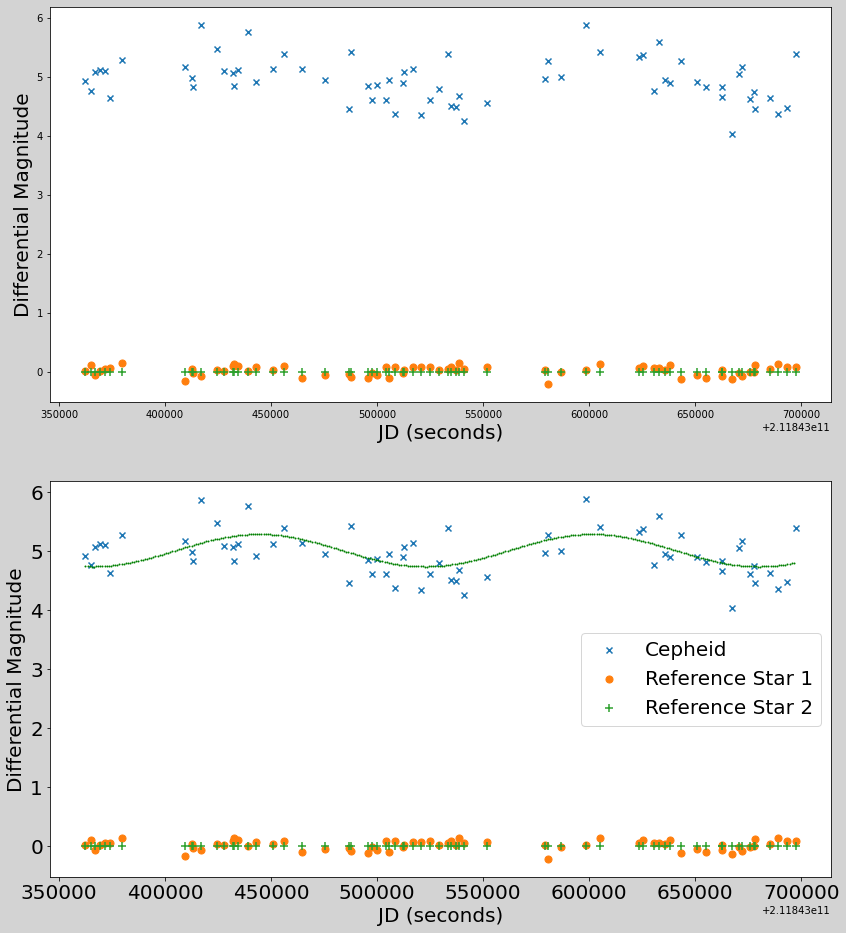

In [162]:
fig, ax = plt.subplots(2,1, figsize=(14,16))

fig.patch.set_facecolor('lightgrey')

plt.xticks(fontsize= 20) 
plt.yticks(fontsize= 20) 
ax[0].set_ylabel('Differential Magnitude',fontsize=20)
ax[0].set_xlabel('JD (seconds)', fontsize=20)
ax[1].set_ylabel('Differential Magnitude',fontsize=20)
ax[1].set_xlabel('JD (seconds)', fontsize=20)

ax[0].scatter(df['JD(seconds)'],df['diff_mag_1'],marker='x', label='Cepheid')
ax[0].scatter(df['JD(seconds)'],df['diff_mag_2'],s=50,marker='o', label='Reference Star 1')
ax[0].scatter(df['JD(seconds)'],df['diff_mag_3'],s=50,marker='+', label='Reference Star 2')

ax[1].scatter(df['JD(seconds)'],df['diff_mag_1'],marker='x', label='Cepheid')
ax[1].scatter(df['JD(seconds)'],df['diff_mag_2'],s=50,marker='o', label='Reference Star 1')
ax[1].scatter(df['JD(seconds)'],df['diff_mag_3'],s=50,marker='+', label='Reference Star 2')



plt.legend(prop={'size': 20})

params1, params_covariance1 = optimize.curve_fit(test_func, df['JD(seconds)'], df['diff_mag_1'], p0=[.6, 0.00004, 496.5, 5])
print(params1)

ax[1].scatter(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), test_func(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), params1[0], params1[1], params1[2], params1[3]),s=1, c='green')
# ax.scatter(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), test_func(np.arange(df['JD(seconds)'].min(),df['JD(seconds)'].max(), 1000), .6, 0.00004, 496.5, params1[3]),s=1, c='red')

# plt.savefig('diff-mag.png')

## Lomb-Scargle Method

0.3216957898276361


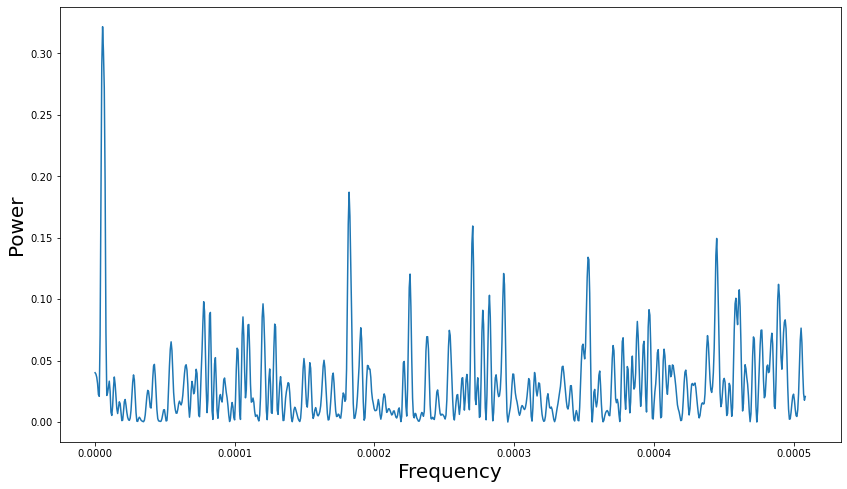

In [95]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
ax.set_ylabel('Power',fontsize=20)
ax.set_xlabel('Frequency', fontsize=20)
frequency, power = LombScargle(new['JD(seconds)'], new['diff_mag_1']).autopower()
plt.plot(frequency, power, )     
print(power.max())

## Period

In [163]:
result = np.where(power == power.max())
frequency[result]
ls_P = 1/frequency[result] # period from lomb-scargle application
cv_P = 2*np.pi/(params1[1]) # period from curve_fit() 
mf_P = 2*np.pi/(0.00004)  # period from manual fit
# ls_P[0]/86400, cv_P/86400, mf_P/86400
print("From Lomb-Scargle method: ",np.round(ls_P[0]/86400,4),"\nFrom curve fitting: ", np.round(cv_P/86400,4))

From Lomb-Scargle method:  2.0397 
From curve fitting:  1.8181


In [47]:
df['diff_mag_1'].mean(), params1[3]

(4.945712243205512, 5.013660323562017)

## Absolute Magnitude From P-L Relation

In [137]:
ls_M_v1 = -2.43*(np.log10(ls_P/86400)-1)-4.05
cv_M_v1 = -2.43*(np.log10(cv_P/86400)-1)-4.05
mf_M_v1 = -2.43*(np.log10(mf_P/86400)-1)-4.05
print("From Lomb-Scargle method: ",np.round(ls_M_v1[0],4),"\nFrom curve fitting: ", np.round(cv_M_v1,4))

From Lomb-Scargle method:  -2.3723 
From curve fitting:  -2.2508


## Apparent Magnitude

In [131]:
m_v3 = 14.8
m_v1 = params1[3] + m_v3
m_v1

19.81366032356202

## Distance Modulus

In [165]:
ls_distance = 10**(1+(m_v1 - ls_M_v1[0])/5)
cv_distance = 10**(1+(m_v1 - cv_M_v1)/5)
mf_distance = 10**(1+(m_v1 - mf_M_v1)/5)
print("From Lomb-Scargle method: ",np.round(ls_distance*3.26/1000000,4),"Mly\nFrom curve fitting: ", np.round(cv_distance*3.26/1000000,4),"Mly")

From Lomb-Scargle method:  0.8921 Mly
From curve fitting:  0.8436 Mly


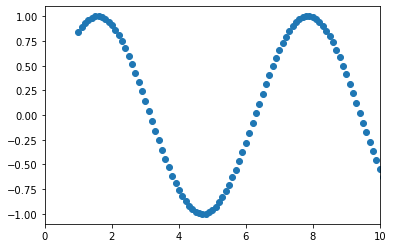

In [82]:
# # %matplotlib qt
# fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(10,10))
fig, ax = plt.subplots(1,1)

ax.set_xlim([0,10])
a = np.arange(1,1000,.1)
b = np.sin(a)
ax.scatter(a,b)
plt.show()

# py.iplot(data, filename='jupyter-basic_bar')


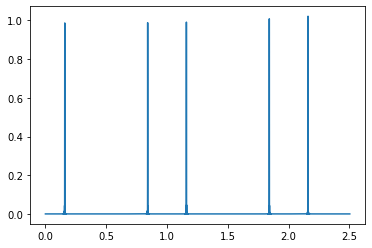

In [74]:
fig, ax = plt.subplots(1,1)
frequency, power = LombScargle(a,b).autopower()
ax.plot(frequency, power)     